In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime
import pandas as pd
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definimos variables globales:
SCROLL_PAUSE_TIME = 0.5
DRIVER_DIR = "C:\\chromedriver_win32\\chromedriver.exe"
OUTPUT_DIR = "C:\\Users\\Matias\\Documents\\Matias\\Repositorios\\de_ruedas_ws\\outputs"

In [3]:
# Especificamos mapeos
map_order = {
    'Destacados': 1,
    'Más Nuevos': 2,
    'Más Antiguos': 3,
    'Más Caros': 4,
    'Más Baratos': 5,
    'Últimos Publicados': 6,
}

def get_id_precio(px):
    return int(px/100000)

In [4]:
# definimos parámetros de búsqueda
order = 'Últimos Publicados'
precio_min = 0 
precio_max = 8_000_000
kilometraje_max = 200000
anio_min = 2008
anio_max = datetime.now().year
brands = [
          # 'Alfa Romeo',
          # 'Audi',
          # 'BMW',
          # 'Chery',
          # 'Chevrolet',
          # 'Citroen',
          # 'DS',
          # 'Fiat',
          'Ford',
          # 'Geely',
          # 'Haval',
          # 'Honda',
          # 'Hyundai',
          # 'Jeep',
          # 'Kia',
          # 'Land Rover',
          # 'Mercedes Benz',
          # 'Mini Cooper',
          # 'Nissan',
          # 'Peugeot',
          # 'Renault',
          # 'Toyota',
          # 'Volkswagen',
          ]

### Función para cargar todos los autos de una marca

In [5]:
def get_browse_charged(brand):
    link = f"https://www.deruedas.com.ar/bus.asp?segmento=0&anio_1={anio_min}&anio_2={anio_max}&kilometraje={kilometraje_max}&precio_1={get_id_precio(precio_min)}&precio_2={get_id_precio(precio_max)}&order={map_order[order]}&marca={brand}"
    browser = webdriver.Chrome(DRIVER_DIR)
    browser.get(link)

    last_height = browser.execute_script("return document.body.scrollHeight")
    while True:
        # Scroll down to bottom
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = browser.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    return browser

### Función para obtener dolar

In [6]:
def get_usd_blue_price():
    link = "https://dolarhoy.com/cotizaciondolarblue"
    browser = webdriver.Chrome(DRIVER_DIR)
    browser.get(link)

    soup = BeautifulSoup(browser.page_source,"html.parser",multi_valued_attributes=None)
    browser.close()
    
    dolar_page = soup.findAll("div", {"class": 'value'})
    
    return float(dolar_page[1].text.replace('$',''))

### Cargar la página por marca, ingresar a cada auto y guardar la data.

In [7]:
pd_datos_autos = pd.DataFrame()
for brand in brands:
    browser = get_browse_charged(brand)

    soup = BeautifulSoup(browser.page_source,"html.parser",multi_valued_attributes=None)
    soup_autos = soup.findAll("div", {"id": lambda value: value and value.startswith("car_")})

    lst_id_autos = []
    lst_link_autos = []
    for auto in soup_autos:
        lst_id_autos.append(auto.get('id'))
        lst_link_autos.append(f'https://www.deruedas.com.ar{auto.find("a").get("href")}')

    lst_dict_datos_auto = []
    for id_auto, link_auto in zip(lst_id_autos, lst_link_autos):
        dict_datos_auto = {}
        dict_datos_auto['id'] = id_auto
        dict_datos_auto['day'] = str(datetime.now().date())
        dict_datos_auto['marca'] = brand
        dict_datos_auto['link'] = link_auto
        


        # get soup page
        browser.get(link_auto)
        soup = BeautifulSoup(browser.page_source,"html.parser",multi_valued_attributes=None)
        
        # Cuadro superior (info principal)
        soup_info_principal = soup.find("div", {"id": 'divInfoPrincipal'})

        dict_datos_auto['nombre'] = soup_info_principal.find('span', {'class': 'titulo resaltar'}).find('h1').text
        dict_datos_auto['version'] = soup_info_principal.find('span', {'class': 'titulo resaltar'}).find('span').text

        # información de contacto
        soup_info_contacto = soup.find("div", {"id": 'divContactoVehiculo'})

        if soup_info_contacto.find('tbody').find('img') != None:
            dict_datos_auto['es_concesionario'] = 1
        else:
            dict_datos_auto['es_concesionario'] = 0
            
        try:
            dict_datos_auto['link_contacto'] = soup_info_contacto.find('tbody').findAll('a')[1].get('href')
        except:
            dict_datos_auto['link_contacto'] = None
            
        try:
            dict_datos_auto['nombre_contacto'] = soup_info_contacto.find('tbody').findAll('a')[1].text
        except:
            try:
                dict_datos_auto['nombre_contacto'] = soup_info_contacto.find('tbody').find('span').text
            except:
                dict_datos_auto['nombre_contacto'] = soup_info_contacto.find('tbody').find('b').text
        try:
            dict_datos_auto['ubicacion'] = soup_info_contacto.find('h2').text
        except:
            dict_datos_auto['ubicacion'] = None
        # Detalles en recuadros
        soup_info_datos = soup.find('div', {'id': 'divFichaVehiculo'}).findAll("div", {"class": 'recuadro'})
        lst_datos = soup_info_datos[0].findAll('b')

        lst_attrs = [
            'segmento',
            'ano',
            'combustible',
            'kilometraje',
            'precio',
            'permuta_por_menor',
            'permuta_por_mayor',
            'ultima_actualizacion',
            'provincia',
            'visitas'
            ]


        for i, dato in enumerate(lst_datos):
            dict_datos_auto[lst_attrs[i]] = dato.text

        dict_datos_auto['equipamiento'] = soup_info_datos[1].find('div', {'class':'texto'}).text
        dict_datos_auto['comentarios_vendedor'] = soup_info_datos[2].find('div', {'class':'texto'}).text.replace('\n','').replace('\t','')

        lst_dict_datos_auto.append(dict_datos_auto)


        # print(dict_datos_auto)
    pd_datos_autos = pd.concat([pd_datos_autos, pd.DataFrame(lst_dict_datos_auto)])
    
    browser.close()
    


In [8]:
# guardamos los datos como csv
pd_datos_autos = pd_datos_autos.set_index('id')
date_str = str(datetime.now().date()).replace('-','_')
pd_datos_autos.to_csv(f'./outputs/{date_str}_ford_autos.csv')

## Análisis

In [9]:
pd_datos_autos = pd.read_csv('./outputs/2023_03_18_ford_autos.csv',index_col='id')
# pd_datos_autos_vw = pd.read_csv('./outputs/2023_03_08_vw_autos.csv',index_col='id')

# pd_datos_autos = pd.concat([pd_datos_autos, pd_datos_autos_vw])

In [10]:
pd_datos_autos.groupby('marca')['marca'].count().sort_values(ascending=False)

marca
Ford    574
Name: marca, dtype: int64

In [11]:
set_equip = set()

pd_datos_autos['moneda'] = ['USD' if startswithU else 'ARS' for startswithU in pd_datos_autos['precio'].str.startswith('U')]
pd_datos_autos['precio'] = pd_datos_autos['precio'].str.replace('U','').str.replace('$','').str.replace('.','').astype(float)
tdc = get_usd_blue_price()
pd_datos_autos['precio_ars'] = [precio * tdc if moneda == 'USD' else precio for moneda, precio in zip(pd_datos_autos['moneda'],pd_datos_autos['precio'])]
pd_datos_autos['precio_usd'] = [precio / tdc if moneda == 'ARS' else precio for moneda, precio in zip(pd_datos_autos['moneda'],pd_datos_autos['precio'])]
pd_datos_autos['kilometraje'] = pd_datos_autos['kilometraje'].str.replace(' Km','').astype(float)
pd_datos_autos['ano'] = [int(datetime.now().year) if ano == '0 Km' else int(ano) for ano in pd_datos_autos['ano']]

for equip in pd_datos_autos['equipamiento'].str.split(','):
    equip = [eq.strip() for eq in equip]
    set_equip.update(set(equip))


lst_equip = list(set_equip)
for equip in list(set_equip):
    pd_datos_autos[equip] = [1 if equip in lst_eq else 0 for lst_eq in pd_datos_autos['equipamiento']]

def elimina_tildes(txt):
    return txt.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')


pd_datos_autos.columns = [elimina_tildes(eq.lower().replace(' / ','/').replace(' ','_')) for eq in pd_datos_autos.columns]

# del pd_datos_autos['no_especificado']


C:\Users\matia\AppData\Local\Temp\ipykernel_22424\1957329317.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pd_datos_autos['precio'] = pd_datos_autos['precio'].str.replace('U','').str.replace('$','').str.replace('.','').astype(float)


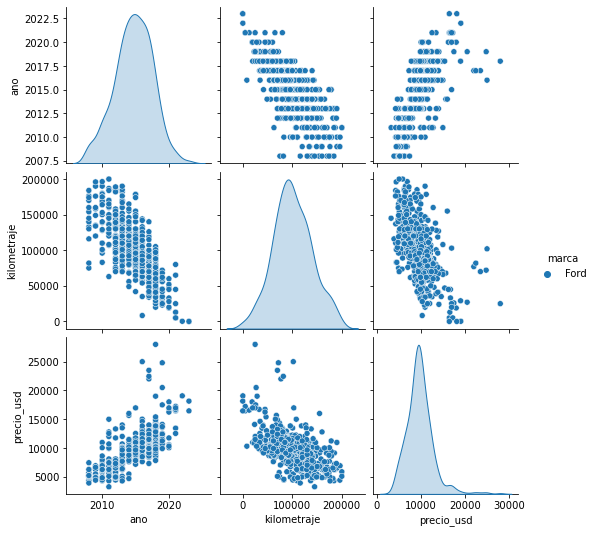

In [12]:
brands_in = [
          'Chevrolet',
          'Citroen',
          'Fiat',
          'Ford',
          'Honda',
          'Nissan',
          'Peugeot',
          'Renault',
          'Toyota',
          'Volkswagen',
          ]
sns.pairplot(pd_datos_autos[pd_datos_autos.apply(lambda x: x['marca'] in brands_in, axis=1)].reset_index()[['ano','kilometraje','precio_usd', 'marca']],hue='marca')

## Kmeans para clasificar tipos de autos según su equipamiento

### Seleccionamos cantidad de Clusters

In [13]:
(pd_datos_autos['no_especificado'] == 1).sum()/pd_datos_autos.shape[0]

0.06620209059233449

In [14]:
# Primero eliminamos el campo "no_especificado" y borramos del dataset los autos que no estén especificados.
del pd_datos_autos['no_especificado']

In [15]:
random_state = 1231
min_col_consider = list(pd_datos_autos.columns).index('precio_usd')+1
X = pd_datos_autos.iloc[:,min_col_consider::]

In [16]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


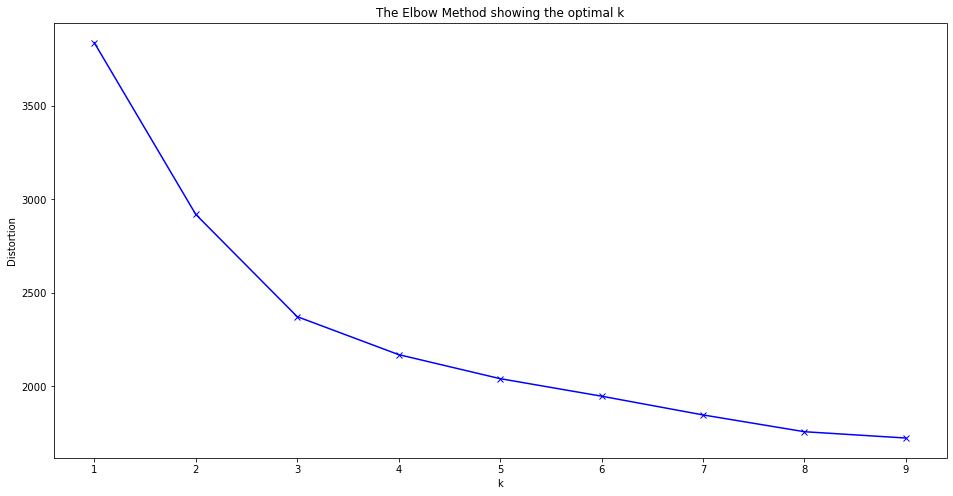

In [17]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Inspeccionamos los clusters

In [18]:
pd.options.display.max_columns = None
n_clusters = 3

In [19]:
pd_datos_autos['cl_equipamiento'] = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)

In [20]:
counts_equip = pd_datos_autos.iloc[:,min_col_consider::].groupby('cl_equipamiento').sum()
count_per_group = pd_datos_autos.groupby('cl_equipamiento')['marca'].count()

gps


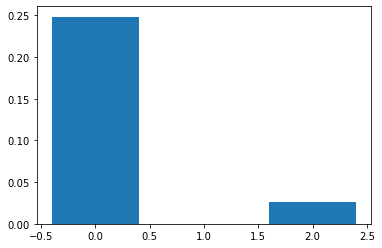

control_de_traccion


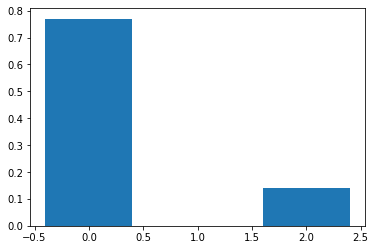

control_de_presion_de_neumaticos


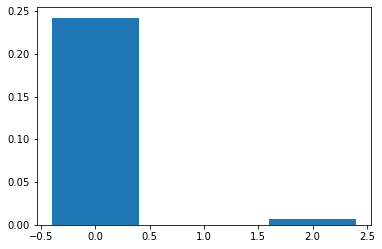

espejo_central_antideslumbrante


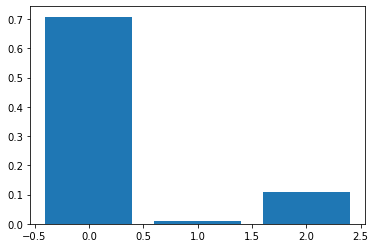

sensor_de_estacionamiento


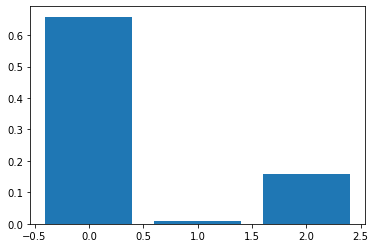

faros_de_xenon


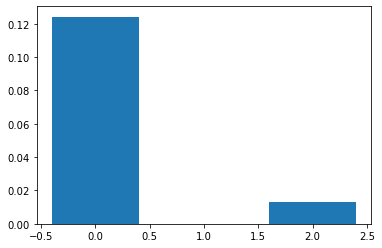

aire_acondicionado


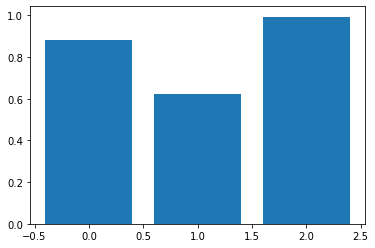

estacionamiento_automatico


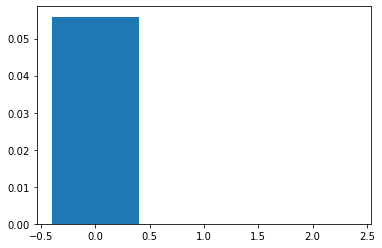

caja_automatica


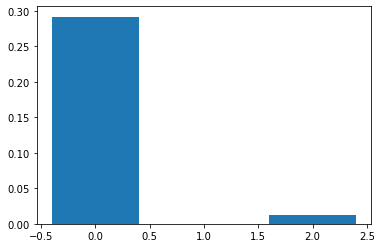

asistente_de_arranque_en_pendientes


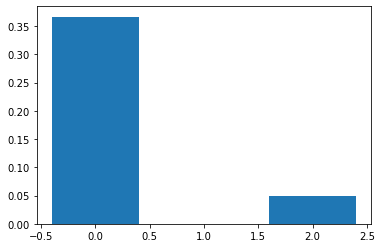

techo_panoramico_o_corredizo


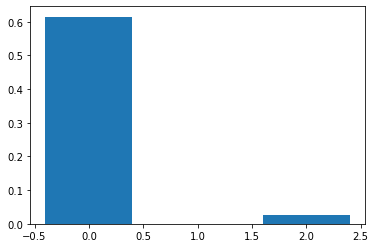

cierre_centralizado


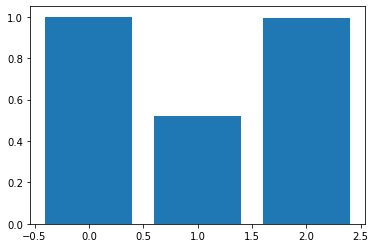

sistema_de_sonido_de_alto_rendimiento


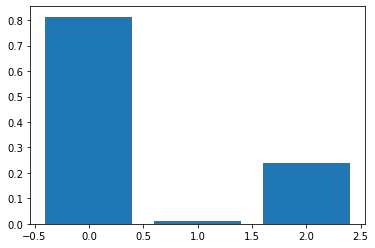

espejos_exteriores_retractiles_electricos


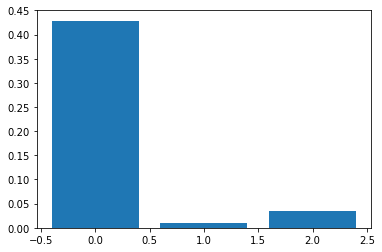

comandos_en_el_volante/satelital


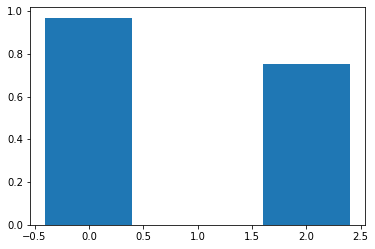

limpia/lava_faros


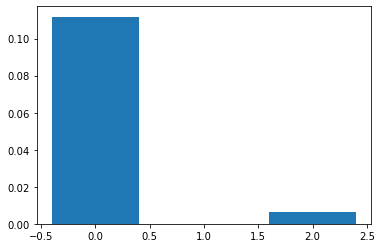

sistema_de_frenado_automatico


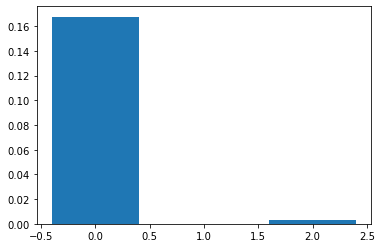

llantas_de_aleacion


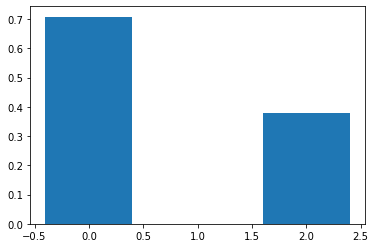

rueda_de_auxilio_de_igual_medida


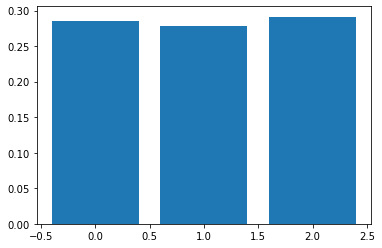

butacas_de_cuero


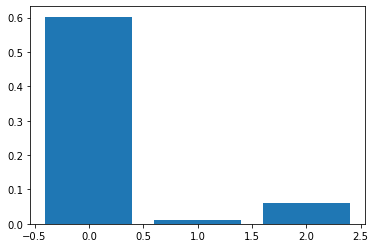

faros_direccionales


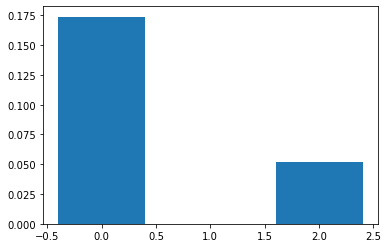

anclaje_de_asientos_infantiles_(isofix)


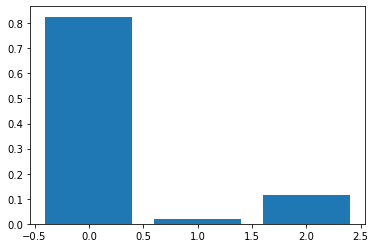

traba_para_niños


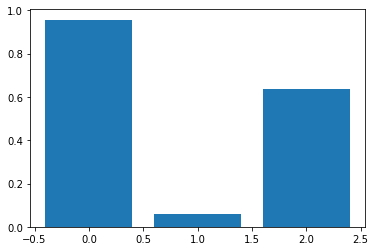

butacas_calefaccionadas


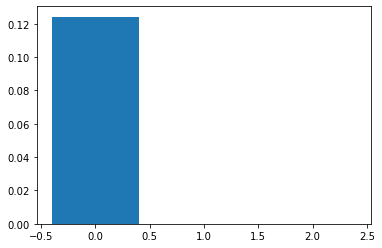

motor_turbo


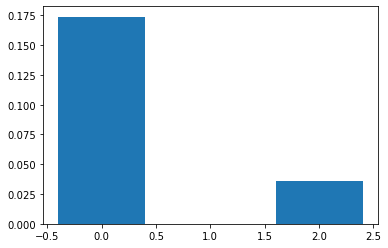

reproduce_cd/dvd


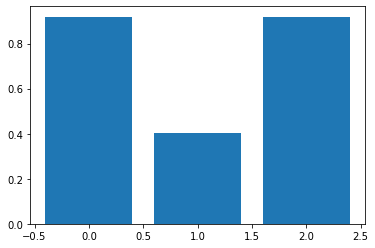

faros_antiniebla


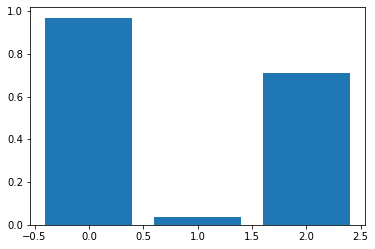

airbags


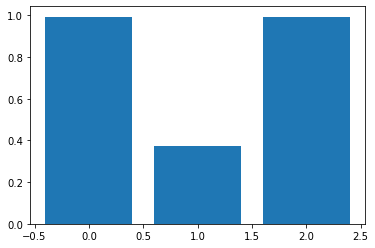

control_de_estabilidad_(esp)


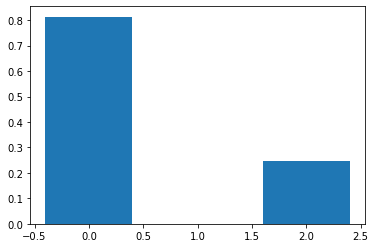

volante_de_cuero


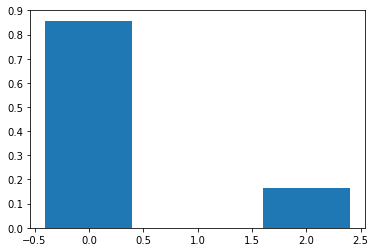

control_de_velocidad_crucero


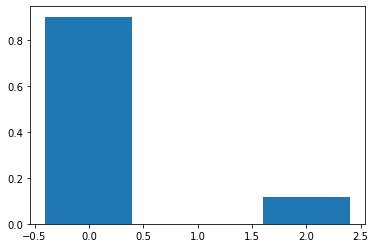

bluetooth


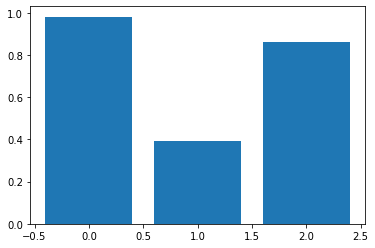

sistema_de_alerta_de_angulo_muerto


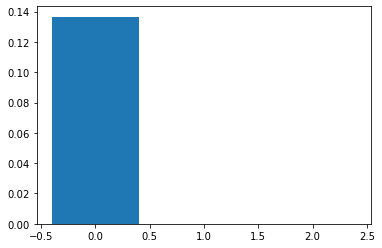

espejos_electricos


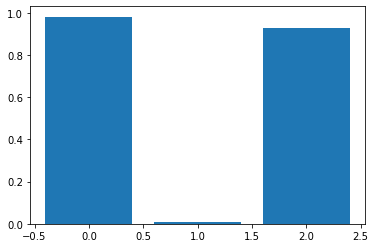

cierre_de_puertas_y_encendido_sin_llave


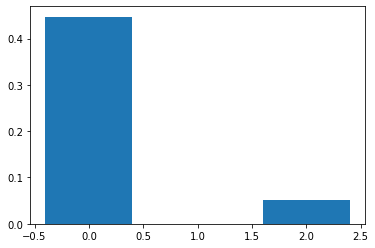

frenos_abs


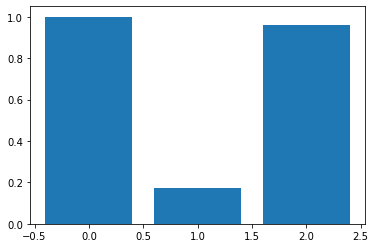

climatizador_automatico


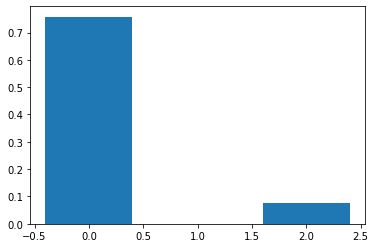

vidrios_electricos


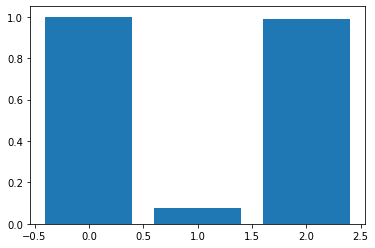

direccion_asistida


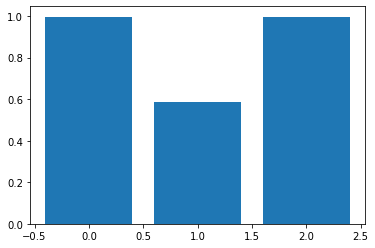

volante_regulable


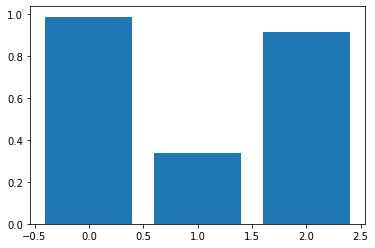

sensor_de_luz


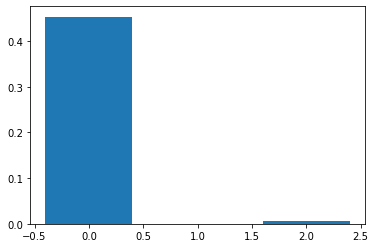

frenos_de_disco_en_las_cuatro_ruedas


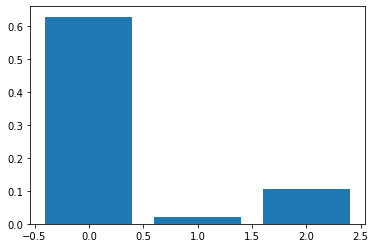

alarma


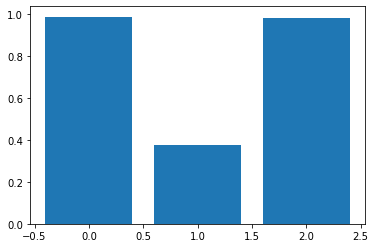

camara_de_estacionamiento_trasera


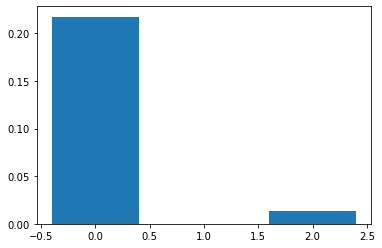

butacas_electricas


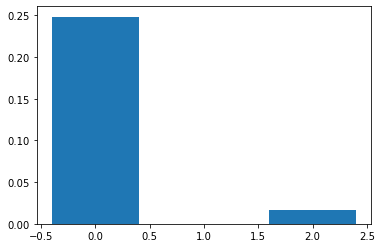

doble_traccion/4x4


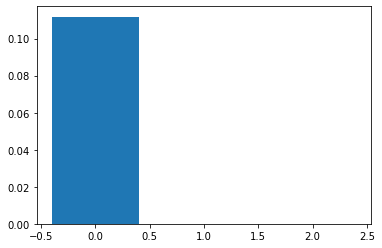

sensor_de_lluvia


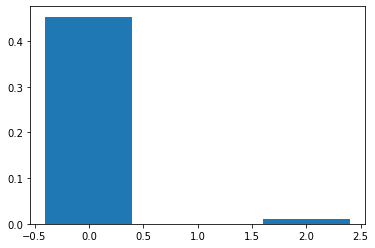

computadora_de_abordo


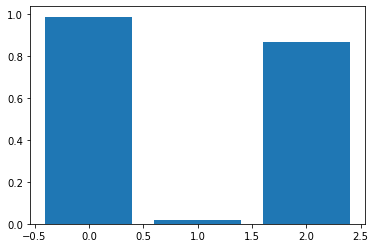

faros_regulables_desde_el_interior


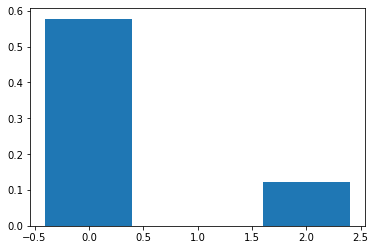

entrada_usb/auxiliar


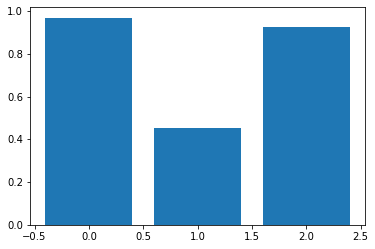

In [21]:
for i, column in enumerate(counts_equip.columns):
    print(column)
    plt.bar(counts_equip.index,counts_equip.iloc[:,i]/count_per_group)
    plt.show()

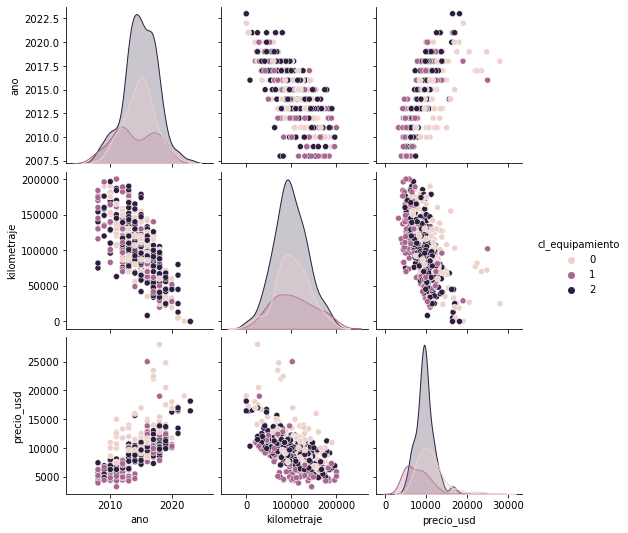

In [22]:
sns.pairplot(pd_datos_autos[pd_datos_autos.apply(lambda x: x['marca'] in brands_in, axis=1)].reset_index()[['ano','kilometraje','precio_usd', 'cl_equipamiento']],hue='cl_equipamiento')

In [23]:
corr = pd_datos_autos[['kilometraje', 'ano', 'precio_usd']].corr()
corr.style.background_gradient(cmap='coolwarm')

,kilometraje,ano,precio_usd
kilometraje,1.000000,-0.744013,-0.549978
ano,-0.744013,1.000000,0.672078
precio_usd,-0.549978,0.672078,1.000000


## Generamos un modelo por cluster de equipamiento

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
pd_datos_autos.segmento

id
car_578829    Autos Usados
car_578808    Autos Usados
car_578800    Autos Usados
car_578799    Autos Usados
car_578779    Autos Usados
                  ...     
car_470334    Autos Usados
car_465666    Autos Usados
car_456621    Autos Usados
car_454480    Autos Usados
car_369301    Autos Usados
Name: segmento, Length: 574, dtype: object

In [26]:
pd_datos_autos = pd.concat([pd_datos_autos, 
                            pd.get_dummies(pd_datos_autos.cl_equipamiento),
                            pd.get_dummies(pd_datos_autos.segmento)], axis=1)

In [27]:
brands_in

['Chevrolet',
 'Citroen',
 'Fiat',
 'Ford',
 'Honda',
 'Nissan',
 'Peugeot',
 'Renault',
 'Toyota',
 'Volkswagen']

In [30]:
# pd_model = pd_datos_autos[pd_datos_autos.marca == 'Citroen']
pd_model = pd_datos_autos[pd_datos_autos.marca == 'Ford']
# pd_model = pd_datos_autos[pd_datos_autos.marca == 'Toyota']
# pd_model = pd_datos_autos[pd_datos_autos.marca == 'Chevrolet']
# pd_model = pd_datos_autos[pd_datos_autos.marca == 'Volkswagen']
# pd_model = pd_datos_autos

In [31]:

X = pd_model[['ano', 'kilometraje', 0, 1, 2, 'Autos Usados']]

y = pd_model['precio_usd']
reg = LinearRegression().fit(X, y)


C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
reg.score(X, y)

C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.5552185177567115

In [33]:
reg.coef_

array([ 5.81660895e+02, -1.09264416e-02,  1.45684629e+03, -1.26364041e+03,
       -1.93205884e+02, -1.91628131e+03])

In [34]:
reg.intercept_


-1159209.1345371979

In [36]:
pd_model['prediccion'] = reg.predict(X)

C:\Users\matia\miniconda3\envs\deruedas\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [37]:
pd_model['dif_pred'] = pd_model['prediccion'] - pd_model['precio_usd']

In [38]:
pd_model.sort_values('dif_pred',ascending = False).iloc[0][['cl_equipamiento','precio_usd','prediccion','dif_pred']]

cl_equipamiento               0
precio_usd          9386.422977
prediccion         13046.862019
dif_pred            3660.439043
Name: car_569199, dtype: object

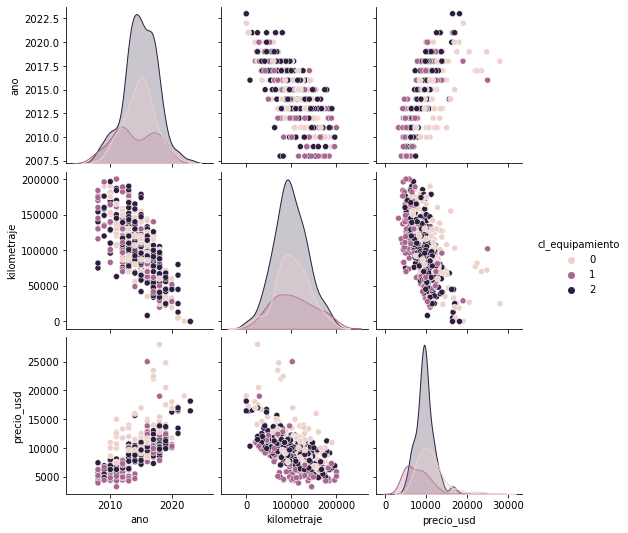

In [39]:
sns.pairplot(pd_model[pd_model.apply(lambda x: x['marca'] in brands_in, axis=1)].reset_index()[['ano','kilometraje','precio_usd', 'cl_equipamiento']],hue='cl_equipamiento')

In [190]:
pd_model = pd_model.sort_values('dif_pred',ascending = False)

In [46]:
pd_model.loc["car_566392"]["link"]

'https://www.deruedas.com.ar/vendo/Ford/Fiesta-KD/Usado/Mendoza?cod=566392&montoEntrega=11000000'

In [191]:
pd_model.shape

(909, 89)

,day,marca,link,nombre,version,es_concesionario,link_contacto,nombre_contacto,ubicacion,segmento,ano,combustible,kilometraje,precio,permuta_por_menor,permuta_por_mayor,ultima_actualizacion,provincia,visitas,equipamiento,comentarios_vendedor,moneda,precio_ars,precio_usd,gps,control_de_traccion,control_de_presion_de_neumaticos,espejo_central_antideslumbrante,sensor_de_estacionamiento,faros_de_xenon,aire_acondicionado,estacionamiento_automatico,caja_automatica,asistente_de_arranque_en_pendientes,techo_panoramico_o_corredizo,cierre_centralizado,sistema_de_sonido_de_alto_rendimiento,espejos_exteriores_retractiles_electricos,comandos_en_el_volante/satelital,limpia/lava_faros,sistema_de_frenado_automatico,llantas_de_aleacion,rueda_de_auxilio_de_igual_medida,butacas_de_cuero,faros_direccionales,anclaje_de_asientos_infantiles_(isofix),traba_para_niños,butacas_calefaccionadas,motor_turbo,reproduce_cd/dvd,faros_antiniebla,airbags,control_de_estabilidad_(esp),volante_de_cuero,control_de_velocidad_crucero,bluetooth,sistema_de_alerta_de_angulo_muerto,espejos_electricos,cierre_de_puertas_y_encendido_sin_llave,frenos_abs,climatizador_automatico,vidrios_electricos,direccion_asistida,volante_regulable,sensor_de_luz,frenos_de_disco_en_las_cuatro_ruedas,alarma,camara_de_estacionamiento_trasera,butacas_electricas,doble_traccion/4x4,sensor_de_lluvia,computadora_de_abordo,faros_regulables_desde_el_interior,entrada_usb/auxiliar,cl_equipamiento,0,1,2,Autos Nuevos,Autos Usados,prediccion,dif_pred
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
car_578631,2023-03-18,Ford,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,Ford Fiesta KD,(L10) 1.6 5ptas Titanium,0,NaN,Facundo,"Mendoza, Godoy Cruz",Autos Usados,2012,GNC,139000.0,3100000.0,SI,SI,Hoy,Mendoza,6,"Aire acondicionado, Climatizador automático, D...","Impecable estado, gnc de 5ta generación autono...",ARS,3100000.0,8093.994778,0,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,9114.375764,1020.380986
car_578001,2023-03-18,Ford,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,Ford Fiesta KD,(L13) 1.6 5ptas SE,0,NaN,Pablo,"Mendoza, Capital",Autos Usados,2017,Nafta,58000.0,3850000.0,NO,NO,Ayer,Mendoza,123,"Aire acondicionado, Dirección asistida, Cierre...",El auto cuenta con toda su documentación y al ...,ARS,3850000.0,10052.219321,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,1,0,1,2,0,0,1,0,1,11257.669833,1205.450512
car_577562,2023-03-18,Ford,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,Ford Fiesta KD,(L13) 1.6 5ptas S Plus,0,NaN,Valentín,"Mendoza, Godoy Cruz",Autos Usados,2016,Nafta,103000.0,3400000.0,SI,SI,Hoy,Mendoza,30,"Aire acondicionado, Dirección asistida, Cierre...",Vehículo en excelente estado . Segundo dueño. ...,ARS,3400000.0,8877.284595,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1,2,0,0,1,0,1,10184.319066,1307.034471
car_578547,2023-03-18,Ford,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,Ford Fiesta KD,(L13) 1.6 5ptas S,0,NaN,Mónica,"Mendoza, Guaymallén",Autos Usados,2014,Nafta,120000.0,3000000.0,NO,NO,Ayer,Mendoza,4,No Especificado,Muy lindo auto. Dueña. Titular. Vendo.,ARS,3000000.0,7832.898172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,7764.813244,-68.084928
car_578529,2023-03-18,Ford,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,Ford Fiesta KD,(L13) 1.6 4ptas Titanium,0,NaN,Luis,"Santa Fe, Rosario",Autos Usados,2015,Nafta,89000.0,3300000.0,NO,NO,Ayer,Santa Fe,3,"Aire acondicionado, Climatizador automático, D...","Servicios al día, cambio de correa tensores y ...",ARS,3300000.0,8616.187990,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,0,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,11405.680530,2789.492540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [44]:
pd_model[pd_model.nombre=="Ford Fiesta KD"][["link", "precio_usd","precio_ars", "ano", "kilometraje"]][:40]

,link,precio_usd,precio_ars,ano,kilometraje
id,,,,,
car_578631,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,8093.994778,3100000.0,2012,139000.0
car_578001,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,10052.219321,3850000.0,2017,58000.0
car_577562,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,8877.284595,3400000.0,2016,103000.0
car_578547,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,7832.898172,3000000.0,2014,120000.0
car_578529,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,8616.187990,3300000.0,2015,89000.0
car_578443,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,10443.864230,4000000.0,2018,57490.0
car_551212,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,9503.916449,3640000.0,2017,55000.0
car_578349,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,9138.381201,3500000.0,2015,130000.0
car_572167,https://www.deruedas.com.ar/vendo/Ford/Fiesta-...,10313.315927,3950000.0,2017,72000.0


In [ ]:
for i in range(30):
    print(pd_model.sort_values('dif_pred',ascending = False).iloc[i]['link'])